<h1 style="font-size:30px;">Unlock the Power of Fine-Tuning Pre-Trained Models in Tensorflow & Keras</h1>  

In a previous notebook, we showed how to use pre-trained models in Keras to perform image classification. Here we will explore options for leveraging pre-trained models you can Fine-Tune to achieve improved performance. This is especially useful when you have a limited dataset and limited computational resources. We will first summarize several options for leveraging pre-trained models, which include:

1. Using Pre-Trained models out of the box.
2. Training models from scratch
3. Transfer Learning
4. Fine-Tuning

The real power comes from Fine Tuning, which is the focus of this notebook.

<img src='https://learnopencv.com/wp-content/uploads/2023/03/tensorflow-keras-fine-tune-architecture-feature-image-2.png' width=900 align='center'>



## Table of Contents

* [1 Overview of Training Options](#1-Overview-of-Training-Options)
* [2 Download and Extract the Dataset](#2-Download-and-Extract-the-Dataset)
* [3 Dataset and Training Configuration](#3-Dataset-and-Training-Configuration)
* [4 Create Train and Validation Datasets](#4-Create-Train-and-Validation-Datasets)
* [5 Create the Test Dataset](#5-Create-the-Test-Dataset)
* [6 Modeling VGG-16 (for Fine-Tuning)](#6-Modeling-VGG-16-(for-Fine-Tuning))
* [7 Model Evaluation](#7-Model-Evaluation)
* [8 Conclusion](#8-Conclusion)

## 1 Overview of Pre-Trained Model Use Cases

Before we proceed with the coding implementation for Fine Tuning, it's helpful to review the table below, which summarizes several use cases. In a previous notebook, we showed how you can use pre-trained ImageNet models to perform classification. 

### 1.1 Pre-Trained ImageNet Models

If you have a need to perform image classification on a wide range of content that encompasses many of the classes in ImageNet, then using a pre-trained model is an excellent choice. As the name implies, no training is required; you can simply load the model and make predictions on your pre-processed input images. There are many pre-trained models available in Keras, which you can select from. See our previous post on this topic for more details.

For situations where your application contains specific classes that are not contained in ImageNet, you have three additional options. The Keras API conveniently provides access to many CNN classification models, which you can load into memory, customize, and train.

<img src=https://learnopencv.com/wp-content/uploads/2023/03/tensorflow-keras-training-methods.png width=900 align='left'><br/>

The sections below summarize the process for each option. It's worth emphasizing that for each training method below, a new classifier needs to be defined for your custom dataset since the pre-trained models in Keras assume an ImageNet classifier with 1,000 outputs. We will cover how to do this in the coding implementation later on in this notebook.

### 1.2 Train from Scratch

If you need to customize a model for a new dataset, one option is to load a model and train it from scratch. When training from scratch, the entire model is initialized with random weights, and training is performed from scratch (with the redefined classifier).

 Training a model from scratch requires a lot of data and a lot of computational resources, although this depends on the size of the model. Still, it's a significant factor to consider, especially if you don't have much data and acquiring labeled training data for your application is difficult. Better options exist, but for reference, we trained the VGG-16 model from scratch on this small dataset to establish a baseline performance. No attempt was made to tune hyper-parameters, but we did use a dropout layer in the classifier, which is needed to mitigate over-fitting with such a small dataset. We will come back to these plots later and compare them to the fine-tuning results.

### 1.3 Transfer Learning

Transfer Learning is a simple approach for re-purposing a pre-trained model to make predictions on a new dataset. The concept is simple. We use the model's pre-trained feature extractor (convolutional base) and re-train a new classifier to learn new weights for the new dataset. This is sometimes referred to as "freezing" the layers in the feature extractor, meaning that we load the pre-trained weights and do not attempt to modify them further during the training process. The theory is that the pre-trained ImageNet Feature Extractor has learned valuable features for detecting many different object types. We assume such features are general enough that we only need to re-train the classifier portion of the network. 

This approach requires much less data and computational resources than training from scratch. Remember that training a model often takes many iterations to determine an appropriate set of hyper-parameters for a final model, so the time required to experiment and iterate will be significantly compounded. Since pre-trained models were trained on millions of images, it behooves us to try and leverage that inherent capability. Transfer learning allows you to quickly study how a pre-trained model can be customized for a new dataset. However, sometimes retraining the classifier isn't enough. This is where Fine-Tuning can be very beneficial.

### 1.4 Fine Tuning

Fine-Tuning represents a flexible alternative to Transfer Learning. It is very similar to Transfer Learning, but instead of locking down the feature extractor completely, we load the feature extractor with ImageNet weights and then freeze the first several layers of the feature extractor but allow the last few layers to be trained further. The idea is that the first several layers in the feature extractor represent generic, low-level features (e.g., edges, corners, and arcs) that are fundamental building blocks necessary to support many classification tasks. Subsequent layers in the feature extractor build upon the lower-level features to learn more complex representations that are more closely related to the content of a particular dataset. 

With Fine-Tuning, we would like to specifically leverage the lower-level features of the pre-trained model but provide some flexibility for "fine-tuning" the last few layers of the convolutional base to provide the best possible customization for the dataset. So we "freeze" the initial layers (ie, make them non-trainable) and let the model train the last few layers of the feature extractor, as well as the classifier. Notice that all the layers in the feature extractor are initialized to ImageNet weights. Once training begins, the weights in the last few layers of the feature extractor are updated further, which is why this approach is called Fine-Tuning. Also, notice that the weights in the classifier are initialized to small random values since we want the classifier to learn new weights required to classify new content.

In the remainder of this notebook, we will focus on the Fine-Tuning implementation. We will also spend some time preparing the test dataset, which is in a different format than the training and validation datasets. This presents a good opportunity to explore the methods and techniques that are used to manage image data that are organized differently on the file system.

In [1]:
import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import requests
import glob as glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [2]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

## 2 Download and Extract the Dataset

The German Traffic Sign Recognition Benchmark ([GTSRB](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)) is a well-known classification dataset that contains German traffic signs from 43 classes. The entire dataset (Train and Test) contains over 50,000 images. The training set alone contains over 39,000 images.

To demonstrate how to leverage pre-trained models for cases when you may have a limited-size dataset, we have created a small version of the GTSRB dataset, which contains just 40 images per class. It's important to note that many of the images from the dataset are taken from video frames. Therefore many of the images in the original training dataset are near duplicates. We, therefore, created a small version of the dataset by sampling every nth image sample to maintain a wide variety of images rather than using the first 40 samples from each class. Additionally, we created a separate validation dataset from the training dataset for convenience. The training dataset contains 28 images per class, and the validation dataset contains 12 images per class. The following code cells will download and extract the dataset to your local system.

In [3]:
def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

In [4]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [5]:
download_file( 
    'https://www.dropbox.com/s/41o9vh00rervwn9/dataset_traffic_signs_40_samples_per_class.zip?dl=1',
    'dataset_traffic_signs_40_samples_per_class.zip'
)
    
unzip(zip_file='dataset_traffic_signs_40_samples_per_class.zip')

## 3 Dataset and Training Configuration

Here we can use the Python dataclasses module to create two classes to configure data and training parameters conveniently. Notice that we specified `LAYERS_FINE_TUNE = 8`, which is a Fine-Tuning configuration parameter to indicate that we want to Fine-Tune the last eight layers of the VGG-16 model. This is value that you will need to experiment with. You can also try setting this to 4, which would only Fine-Tune the last four layers of the convolutional base. 

In [6]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 43
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
        
    DATA_ROOT_TRAIN:  str = './dataset_traffic_signs_40_samples_per_class/Train'  
    DATA_ROOT_VALID:  str = './dataset_traffic_signs_40_samples_per_class/Valid'
    DATA_ROOT_TEST:   str = './dataset_traffic_signs_40_samples_per_class/Test'
    DATA_TEST_GT:     str = './dataset_traffic_signs_40_samples_per_class/Test.csv'
        
    MAX_TEST_SAMPLES: int = 12630  # Number of Test samples to use from the 12,630 Test dataset
        
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 101
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int   = 8        

## 4 Create Train and Validation Datasets

Here we use `image_dataset_from_directory()`, a very convenient utility in Keras for creating an image dataset. The expected file structure is shown below, where files for each class are contained in a separate class folder. By default, the `class names` are inferred from the class folder names. However, supplying the class names using the class_names argument is also possible. By doing so, we can explicitly set the sequence to be in numerical order, as shown below. This is not required but convenient so that the class index corresponds to the class name.

In [7]:
class_names = []
for i in range(DatasetConfig.NUM_CLASSES):
    class_names.append(str(i))
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42']


We also have the option for how to specify the label encoding. Here we decided to use integer encoding (`label_mode='int'`), rather than one-hot label encoding. Either option can be used, but just be aware there is additional code further below in this implementation that assumes integer encoding.

In [8]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',        # Use integer encoding
                                             class_names=class_names, # Specify order
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',        # Use integer encoding
                                             class_names=class_names, # Specify order
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                            )

Found 1204 files belonging to 43 classes.
Metal device set to: Apple M1 Max
Found 516 files belonging to 43 classes.


2023-03-02 13:20:13.115999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-02 13:20:13.116150: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# Confirm class names are in numerical order as specified by class_names.
print(train_dataset.class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42']


### 4.1 Display Sample Images from Training Dataset

It's always a good idea to visually inspect some of the images from the dataset. As you can see below, the image quality varies significantly.  

In [10]:
class_names = train_dataset.class_names

plt.figure(figsize=(18,10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1): 
     
    # Plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        #truth_idx = np.nonzero(labels_batch[i].numpy()) # Use this for one-hot encoded labels
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

2023-03-02 13:20:14.175503: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## 5 Create the Test Dataset

It was easy to create the training and validation datasets using image_dataset_from_directory(). However, since the images and labels for the Test dataset are stored separately on the filesystem, we'll need to write some custom code to read and load this data. To create the test dataset, we will need to load the images and the labels in memory and combine them to create a (`tf.data.Dataset`) test dataset. Four steps are required:

1. Retrieve the class labels from the provided csv file and store them in a tensor
2. Load the image path names in memory
3. Combine the labels and image paths in a tf.data.Dataset object
4. Load and preprocess the images (and set the dataset batch size)


### 5.1 Load Test Ground Truth Labels

The ground truth labels for the test dataset are listed in a `csv` file (`Test.csv`). The first few samples from the file are shown below for reference.`

<img src=https://learnopencv.com/wp-content/uploads/2023/02/tensorflow-keras-test-dataset-ground-truth.png width=800 align='left'><br/>

We can easily extract the label IDs from this file using a Pandas dataframe. The following code cell reads the test label IDs and stores them in a Python list.

In [ ]:
import pandas as pd

# input_file = './dataset_traffic_signs_40_samples_per_class/Test.csv'
input_file = DatasetConfig.DATA_TEST_GT

dataset = pd.read_csv(input_file)
df = pd.DataFrame(dataset)
cols = [6]
df = df[df.columns[cols]]
label_ids = df['ClassId'].values.tolist()
print("Total number of Test labels: ", len(label_ids))

# Load the requested number of ground truth labels.
print("Using this many Test labels: ", len(label_ids))

Total number of Test labels:  12630
Using this many Test labels:  12630


Next, we convert the Python list to a tensor and print out the first ten labels.

In [12]:
# Convert labels IDs to a tensor.
label_ids = tf.convert_to_tensor(label_ids, dtype=tf.int32)
print(label_ids.shape) 
# Print the first ten class IDs.
print(label_ids[0:10])

(12630,)
tf.Tensor([16  1 38 33 11 38 18 12 25 35], shape=(10,), dtype=int32)


Notice that these labels match the first 10 labels from the ground truth file, which is what we expect.

### 5.2 Load and Process Test Images

Next, we create a list of file paths to each of the images in the Test dataset.

In [13]:
# Get all the path names to the Test images (will prune later)
image_paths = sorted(glob.glob(DatasetConfig.DATA_ROOT_TEST + '/*.png'))

print(len(image_paths))
print('')
# Print the first 5 image paths to confirm.
for idx in range(5):
    print(image_paths[idx])

12630

./dataset_traffic_signs_40_samples_per_class/Test/00000.png
./dataset_traffic_signs_40_samples_per_class/Test/00001.png
./dataset_traffic_signs_40_samples_per_class/Test/00002.png
./dataset_traffic_signs_40_samples_per_class/Test/00003.png
./dataset_traffic_signs_40_samples_per_class/Test/00004.png


### 5.3 Combine images and labels to create the Test dataset

We can now use `from_tensor_slices()` to combine the image paths and image labels in a `tf.data.dataset`.

In [14]:
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths[0:DatasetConfig.MAX_TEST_SAMPLES], 
                                                     label_ids[0:DatasetConfig.MAX_TEST_SAMPLES]))

print(test_dataset) 

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


### 5.4 Load and Preprocess the Images
We still need to load the dataset into memory and pre-process the images. For this, we define three convenience functions for loading and resizing test images in the code cells below.

In [15]:
def preprocess_image(image):
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    return image

In [16]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [17]:
# The tuples are unpacked into the positional arguments of the mapped function.
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

Next, we load and preprocess the images using the test dataset's `map()` method to call the function above.

In [18]:
test_dataset = test_dataset.map(load_and_preprocess_from_path_label)

for image, label in test_dataset.take(1):
    print('Image shape: ',image.shape)

Image shape:  (224, 224, 3)


Finally, we set the batch size of the dataset and print the shape of the image batch along with the labels in the first batch just to confirm we get the expected shape and label IDs.

In [19]:
# Set the batch size for the dataset.
test_dataset = test_dataset.batch(TrainingConfig.BATCH_SIZE)

print(test_dataset)
print('')

for image, label in test_dataset.take(1):
    print('Image batch: ',image.shape)
    print('Label batch: ',label.numpy())

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Image batch:  (32, 224, 224, 3)
Label batch:  [16  1 38 33 11 38 18 12 25 35 12  7 23  7  4  9 21 20 27 38  4 33  9  3
  1 11 13 10  9 11  5 17]


### 5.5 Display Sample Images from the Test Dataset

To confirm we have properly created the test dataset, we will display the images from the first batch. Even though this is a very small sample size, it's pretty clear the test images have a wide range in image quality, with several images severely under-exposed.

In [ ]:
plt.figure(figsize=(15,8))
n = 0
nrows = 4
ncols = 8
for image, label in test_dataset.take(32):
    plt.subplot(nrows,ncols,n+1)
    plt.imshow(image[n].numpy().astype("uint8"))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title(label[n].numpy())
    n += 1
plt.show()

## 6 Modeling VGG-16 (for Fine-Tuning)

The Keras API provides the following utility that is used to instantiate a VGG-16 model. The default settings are shown below for the pre-trained ImageNet model.

```python
tf.keras.applications.vgg16.VGG16(include_top=True, 
                                  weights='imagenet', 
                                  input_tensor=None,
                                  input_shape=None, 
                                  pooling=None, 
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )
```

To configure the model for Fine-Tuning, we will load the model's convolutional base with weights that were learned from the ImageNet dataset. These weights serve as a starting point for Fine-Tuning the model for our dataset. Since we need to redefine the classifier, we will load the model without a classifier (include_top=False), so we can specify our own classifier for the dataset.

For more information on the VGG-16 model available in Keras, refer to the: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16" target="_blank">Keras VGG-16 Model API</a>.

### 6.1 Loading the VGG-16 Convolutional Base 

We begin by creating a model of the VGG-16 convolutional base. We can do this by instantiating the model and setting `include_top = False` which excludes the fully connected layers. We will also instantiate the model with weights that were learned by training the model on the ImageNet dataset `weights='imagenet'`. 


In [21]:
# Specify the model input shape.
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)

print('Loading model with ImageNet weights...')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, # We will supply our own top.
                                                    weights='imagenet',
                                                   )
print(vgg16_conv_base.summary())

Loading model with ImageNet weights...
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooli

### 6.2 Freeze the Initial Layers in the Convolutional Base

Now that we have loaded the convolutional base, we need to lock-done the initial layers so that only the last few laters (`TrainingConfig.LAYERS_FINE_TUNE = 8`) are trainable. There are two ways to specify which layers in the model are trainable (tunable).

1. We can start by making the entire convolutional base trainable by setting the trainable flag to True. Then loop over the initial layers and make them untrainable by setting the same (trainable) flag for each layer to False.

2. We can freeze the entire convolutional base by setting the trainable flag to False, and then loop over the last few layers and set the `trainable` flag to `True`.

We use the first approach in the code cell below. We start by setting the entire convolutional base as "trainable" by setting the `trainabl`e attribute to `True`.

In [22]:
# Set all layers in the convolutional base to Trainable (will FREEZE initial layers further below).
vgg16_conv_base.trainable = True

# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(vgg16_conv_base.layers)

# Freeze the initial layers in the convolutional base.
for model_layer in vgg16_conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

print("\n")
print(f"Configured to fine tune the last", num_layers_fine_tune, "convolutional layers...")
print("\n")
    
print(vgg16_conv_base.summary())

FREEZING LAYER: <keras.engine.input_layer.InputLayer object at 0x28d86b970>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x28afe1460>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x28d851fd0>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x28db8b640>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x28b0f0ac0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x28b109b80>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x29a02df10>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x28b124b50>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x28b116400>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x28b1162b0>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x28b101f40>


Configured to fine tune the last 8 convolutional layers...


Model: "vgg16"
_______________

Notice in the model summary above the number of trainable parameters is now lower.

### 6.3 Add the Classifier

Since we intend to train and use the model to classify traffic signs (43 classes), we will need to add our own classification layer. In this example, we have chosen to use just a single fully connected dense layer that contains 128 nodes, followed by a softmax output layer that contains 43 nodes for each of the 43 classes. The number of dense layers and the number of nodes per layer is a design choice, but the number of nodes in the output layer must match the number of classes in the dataset. Because we are working with a very small dataset (40 samples per class), the model will be prone to overfitting, so we have also added a dropout layer in the classifier. The entire model is then assembled as shown below.

In [23]:
inputs = tf.keras.Input(shape=input_shape)
    
x = tf.keras.applications.vgg16.preprocess_input(inputs)
    
x = vgg16_conv_base(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(TrainingConfig.DROPOUT)(x)
    
# The final `Dense` layer with the number of classes.
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)
    
# The final model.
model_vgg16_finetune = keras.Model(inputs, outputs)

print(model_vgg16_finetune.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                             

## 6.4 Compile and Train the Model

Here we use `SparseCategoricalCrossentropy` since we are using integer-encoded labels. For one-hot encoded labels, the appropriate loss function would be `CategoricalCrossentropy`. Since we included a Softmax layer in the model output, we specify `from_logits=False`. This is the default setting, but it's good practice to be explicit. Alternatively, you can remove the softmax layer in the model and set `from_logits=True`, and the loss function will apply the softmax function internally. The results should be identical. 

In [24]:
# Use this for integer encoded labels.
model_vgg16_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )

In [25]:
# Train the Model.
training_results = model_vgg16_finetune.fit(train_dataset,
                                            epochs=TrainingConfig.EPOCHS,
                                            validation_data=valid_dataset,
                                           )

Epoch 1/101


2023-03-02 13:20:30.924976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - ETA: 0s - loss: 4.5978 - accuracy: 0.0208

2023-03-02 13:20:41.841559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 14s 351ms/step - loss: 4.5978 - accuracy: 0.0208 - val_loss: 3.7490 - val_accuracy: 0.0291
Epoch 2/101
38/38 [==============================] - 13s 345ms/step - loss: 3.7538 - accuracy: 0.0274 - val_loss: 3.7436 - val_accuracy: 0.0465
Epoch 3/101
38/38 [==============================] - 13s 341ms/step - loss: 3.6704 - accuracy: 0.0581 - val_loss: 3.5828 - val_accuracy: 0.0775
Epoch 4/101
38/38 [==============================] - 13s 340ms/step - loss: 3.5945 - accuracy: 0.0606 - val_loss: 3.4326 - val_accuracy: 0.1066
Epoch 5/101
38/38 [==============================] - 13s 339ms/step - loss: 3.4192 - accuracy: 0.0972 - val_loss: 3.2478 - val_accuracy: 0.1279
Epoch 6/101
38/38 [==============================] - 13s 340ms/step - loss: 3.2232 - accuracy: 0.1429 - val_loss: 3.1139 - val_accuracy: 0.2035
Epoch 7/101
38/38 [==============================] - 13s 343ms/step - loss: 2.9950 - accuracy: 0.2010 - val_loss: 2.7863 - val_accuracy: 0.2713
Epoc

38/38 [==============================] - 13s 342ms/step - loss: 0.0085 - accuracy: 0.9967 - val_loss: 0.5147 - val_accuracy: 0.9147
Epoch 58/101
38/38 [==============================] - 13s 343ms/step - loss: 0.0071 - accuracy: 0.9992 - val_loss: 0.5232 - val_accuracy: 0.9205
Epoch 59/101
38/38 [==============================] - 13s 344ms/step - loss: 0.0104 - accuracy: 0.9983 - val_loss: 0.4446 - val_accuracy: 0.9167
Epoch 60/101
38/38 [==============================] - 13s 341ms/step - loss: 0.0045 - accuracy: 0.9975 - val_loss: 0.4202 - val_accuracy: 0.9302
Epoch 61/101
38/38 [==============================] - 13s 342ms/step - loss: 0.0082 - accuracy: 0.9967 - val_loss: 0.3802 - val_accuracy: 0.9205
Epoch 62/101
38/38 [==============================] - 13s 340ms/step - loss: 0.0195 - accuracy: 0.9958 - val_loss: 0.5249 - val_accuracy: 0.8992
Epoch 63/101
38/38 [==============================] - 13s 342ms/step - loss: 0.0281 - accuracy: 0.9917 - val_loss: 0.5752 - val_accuracy: 0.908

### 6.4 Plot the Training Results

The convenience function below is used to plot both the training and validation loss and accuracy.

In [26]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

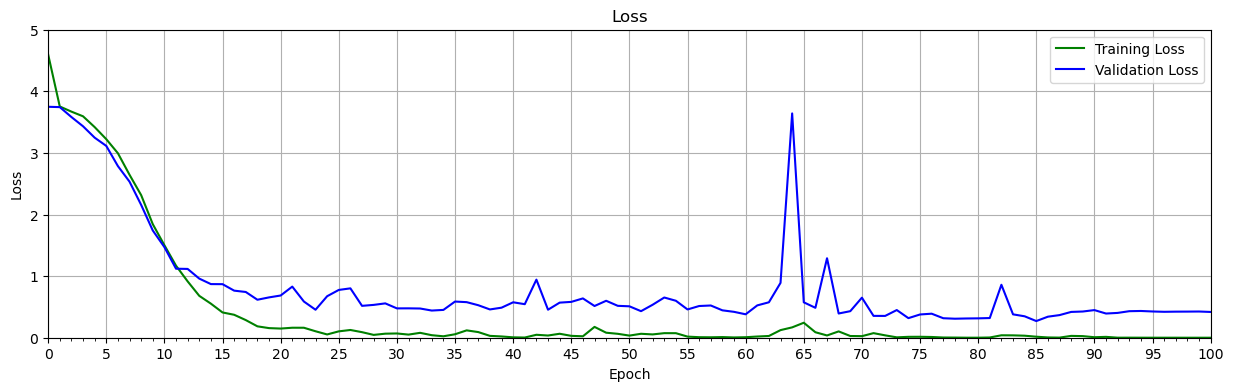

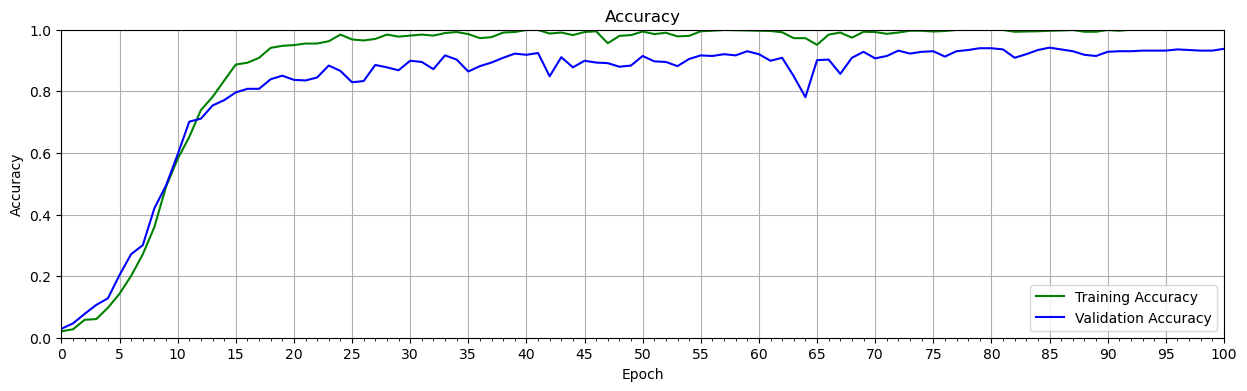

In [27]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
    
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

As shown below, the loss decreases rapidly, and the accuracy increases rapidly. This trend is due to the fact that the model was initialized with pre-trained weights. Also, notice that the validation accuracy is close to 95%, which is quite good considering the small size of the dataset and range in image quality. Techniques such as data augmentation could be used to further improve these results. 

### 6.4.1 Comparison: Fine-Tuning vs. Training from Scratch

For convenience, we have included a side-by-side view to show the difference between training the model from scratch and fine-tuning the model. There are several things to note. First, notice that training from scratch takes longer. For example, the validation accuracy for fine-tuning reaches 80% after just 15 epochs, while training from scratch needs a full 100 epochs to get close to the same value. Also, notice that training from scratch is more prone to over-fitting even though both models were implemented with the same dropout layer in the classifier. Finally, the validation accuracy of the fine-tuned model is about 14% higher.

<img src=https://learnopencv.com/wp-content/uploads/2023/02/tensorflow-keras-model-comparison-plots-1.png width=1000 align='left'><br/>

## 7 Model Evaluation

We can see the train and validation accuracy in the plots above, but it's helpful to use the model's `evaluate()` method to compute the value at the last epoch. Here we confirm that the validation accuracy is nearly 94%.

### 7.1 Validation Dataset

In [28]:
print(f"Model valid accuracy: {model_vgg16_finetune.evaluate(valid_dataset)[1]*100.:.3f}")

17/17 [==============================] - 2s 142ms/step - loss: 0.4183 - accuracy: 0.9380
Model valid accuracy: 93.798


### 7.2 Test Dataset

It's also important to evaluate the model on the Test dataset, which is very large (12,630 images). This is especially true since the number of samples in the validation dataset is pretty small (only 12 samples per class). As shown below, the accuracy achieved on the test dataset is `94.43%` which in this case is very comparable to the validation accuracy, but this won't always be the case.

In [29]:
print(f"Model test accuracy: {model_vgg16_finetune.evaluate(test_dataset)[1]*100.:.3f}")

395/395 [==============================] - 59s 149ms/step - loss: 0.3234 - accuracy: 0.9443
Model test accuracy: 94.426


### 7.3 Display Sample Predictions

Here we create a convenience function to plot some sample predictions from both the validation and test datasets. It can be helpful to visually spot-check prediction results. Each displayed image contains a title with the ground truth label (left) and the predicted label (right). If the predicted label is incorrect, the title is displayed in red to highlight the incorrect result.

In [30]:
def display_predictions(dataset, model, one_hot=False):
    
    plt.figure(figsize=(20,20))
    num_rows = 8
    num_cols = 8
    jdx = 0
    
    # Evaluate all the batches.
    for image_batch, labels_batch in dataset.take(2):
        
        print(image_batch.shape)
        
        # Predictions for the current batch.
        predictions = model.predict(image_batch)
        
        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
            
            pred_idx = tf.argmax(predictions[idx]).numpy()
            if one_hot:
                truth_idx = np.nonzero(labels_batch[idx].numpy())
            else:
                truth_idx = labels_batch[idx].numpy()
            
            # Set the title color based on the prediction.
            if pred_idx == truth_idx:
                color='g'
            else:
                color='r'
                
            jdx += 1
                
            if jdx > num_rows*num_cols:
                # Break from the loops if the maximum number of images have been plotted
                break
                
            ax = plt.subplot(num_rows, num_cols, jdx)
                
            if one_hot:
                title = str(truth_idx[0][0]) + " : " + str(pred_idx)
            else:
                title = str(truth_idx) + " : " + str(pred_idx)
                
            title_obj = plt.title(title)
            plt.setp(title_obj, color=color)
            plt.axis("off")
            plt.imshow(image_batch[idx].numpy().astype("uint8"));
    return 

### 7.3.1 Display Sample Validation Results

Since the number of samples below (64) is rather small and the accuracy is 94%, we might expect just one or two mistakes. However, in this case, all 64 validation samples are correctly classified.

(32, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(32, 224, 224, 3)
1/1 [==============================] - 0s 14ms/step


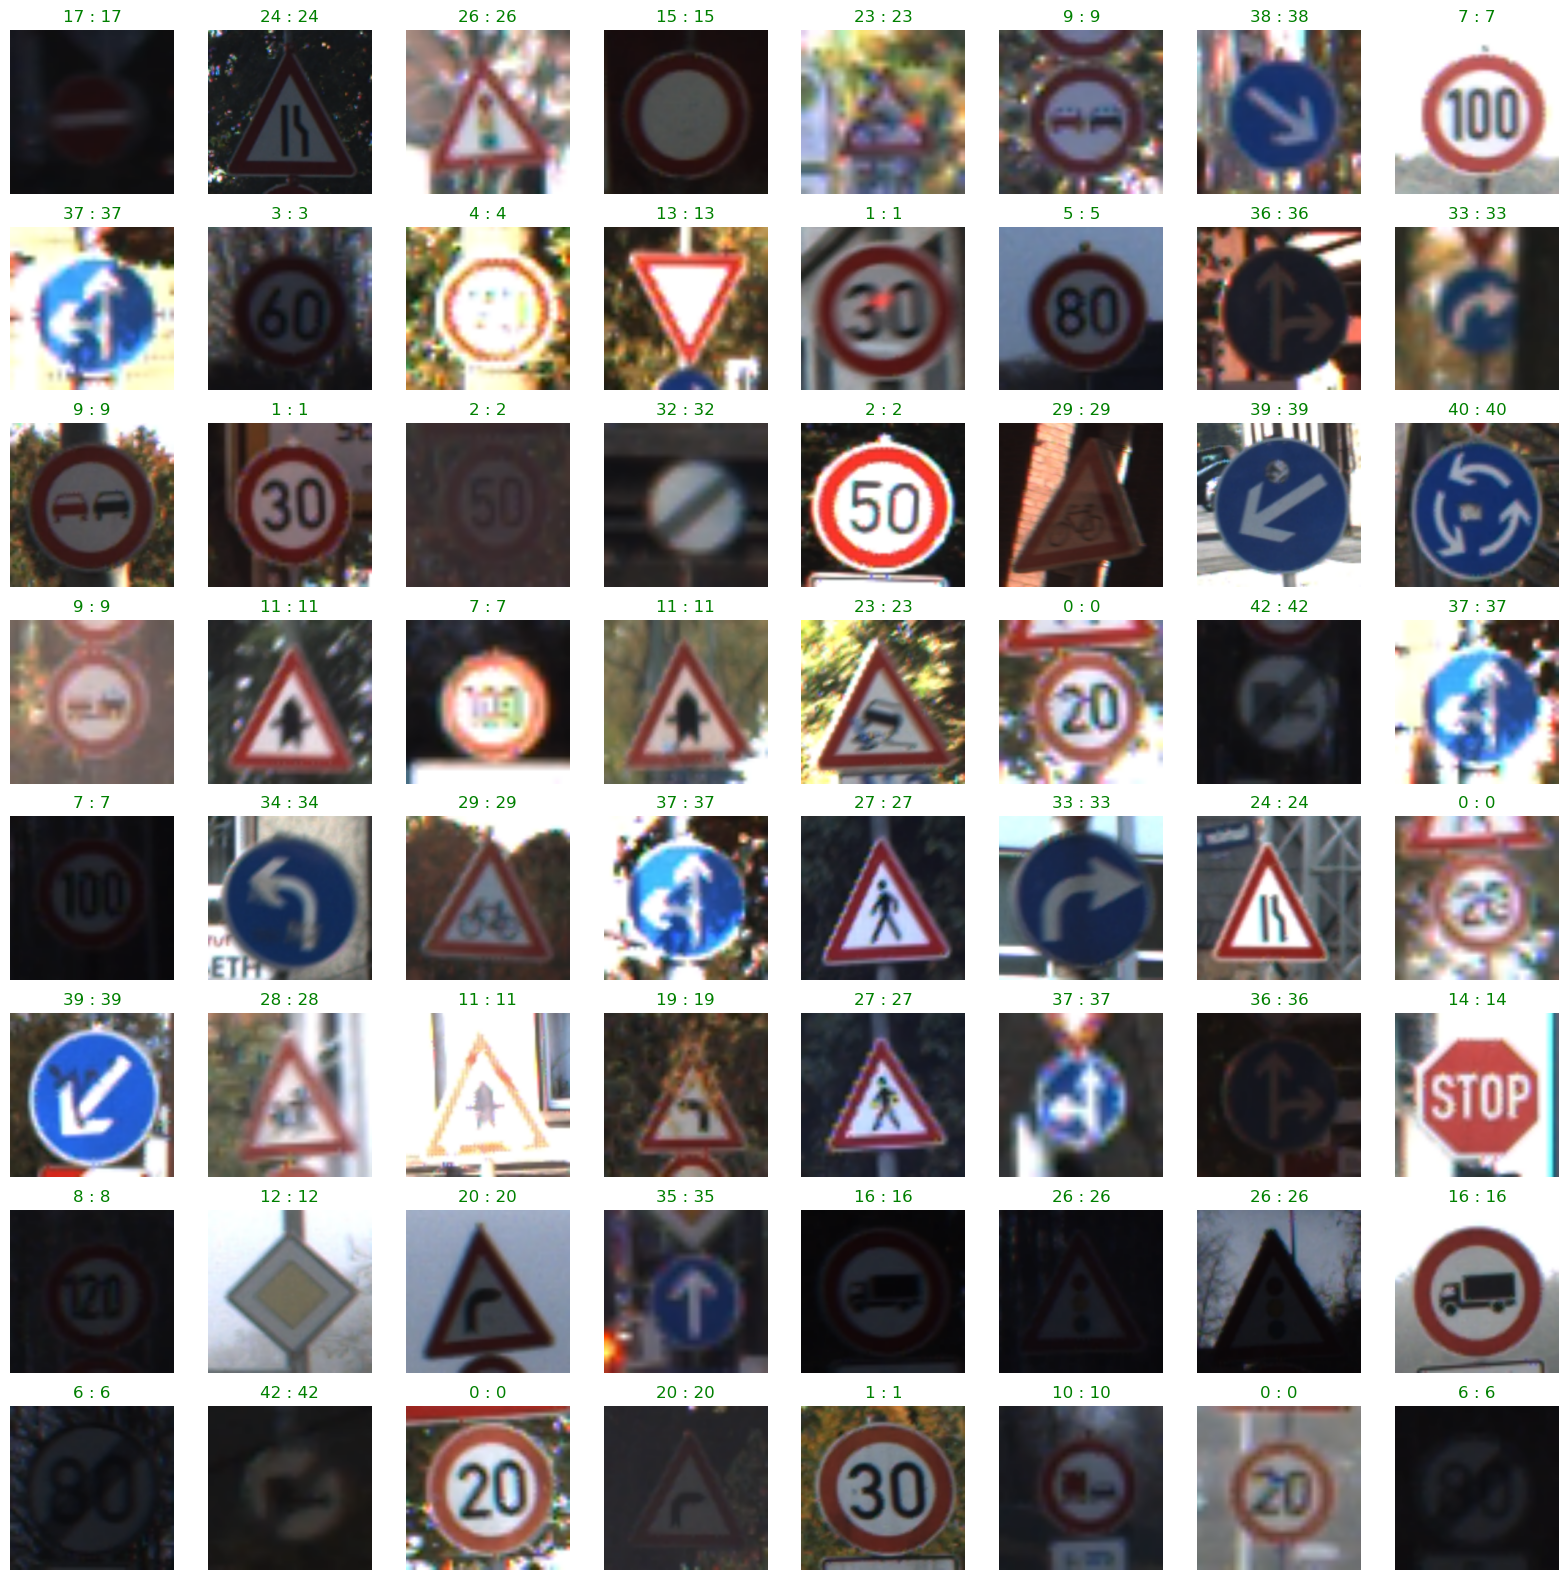

In [36]:
display_predictions(valid_dataset, model_vgg16_finetune)

### 7.3.2 Display Sample Test Results

For the test dataset, we see just one incorrect classification (20 was mistaken for 25), but it's interesting to note that the predicted traffic sign (although incorrect) is very similar to the ground truth (ie, both are triangular-shaped signs).

(32, 224, 224, 3)
1/1 [==============================] - 0s 21ms/step
(32, 224, 224, 3)
1/1 [==============================] - 0s 13ms/step


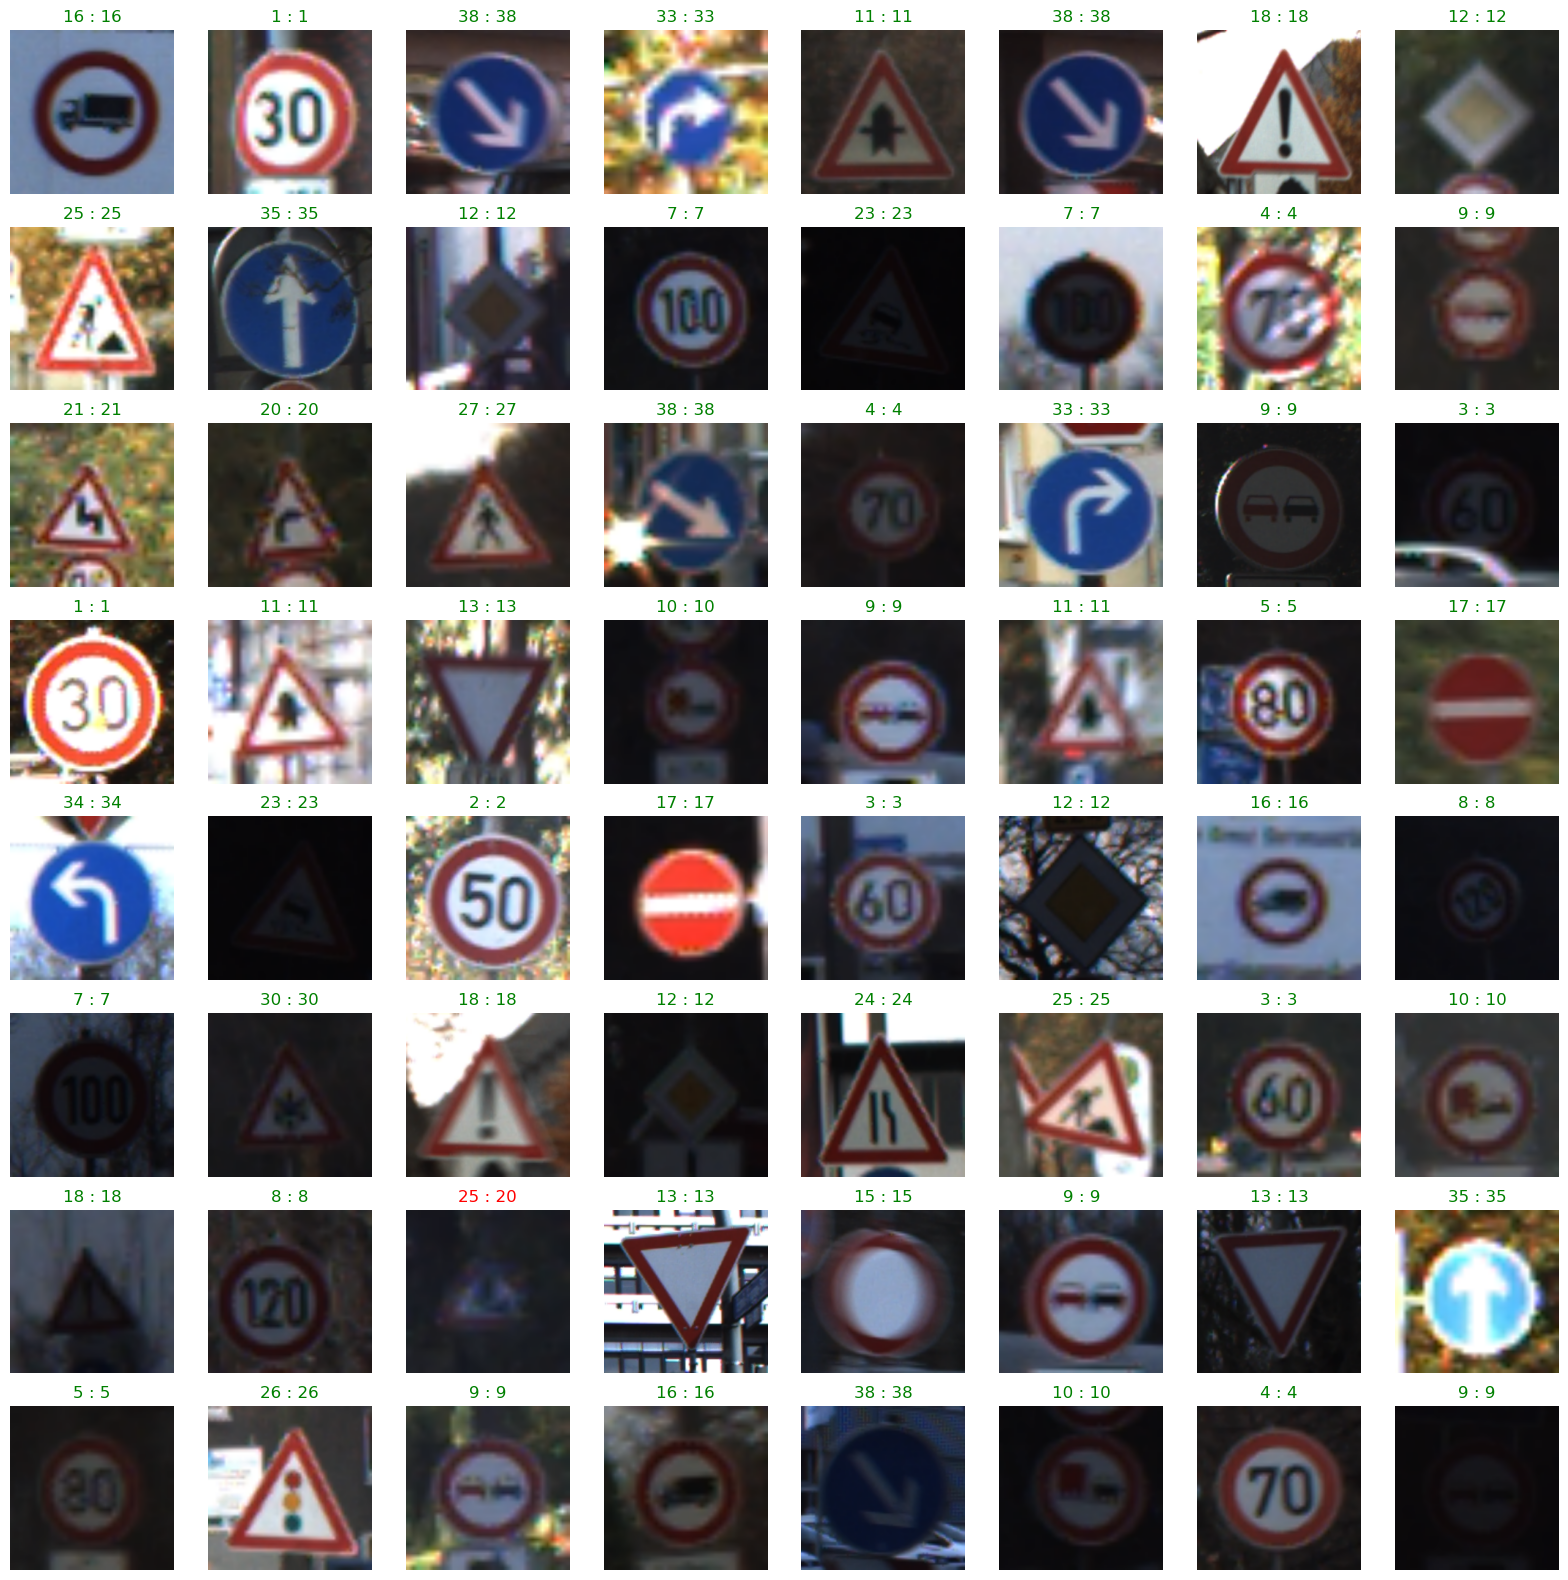

In [41]:
display_predictions(test_dataset, model_vgg16_finetune)

## 8 Conclusion

Fine-tuning pre-trained models is a powerful technique that allows you to re-purpose a model for a custom dataset. Keras comes bundled with many pre-trained classification models to choose from and allows you to conveniently load a model in memory and configure it for Fine-Tuning. Let's summarize the key steps required for fine-tuning a pre-trained model.

When fine-tuning pre-trained models, we only load the convolutional base of the model, which is initialized with ImageNet weights.  We "freeze" the first few layers of the convolutional base but allow the last few layers to be trained ("fine-tuned"). These steps are accomplished with the model's trainable attribute to toggle which layers are trainable and which are not. The number of layers to fine-tune is something you need to experiment with. The classifier needs to be redefined based on the dataset and is initialized with random weights. In this way, the model's initial state is in a favorable position for continued learning that allows it to adapt to a new dataset and learn faster (and potentially better) than training a model from scratch. This approach also allows the model to be re-purposed for a new dataset with much less data than would be required for training a model from scratch.